## Capacity Expansion Planning

Review the problem formulation of the electricity market model. Below you can find an adapted version
where the capacity limits have been promoted to **decision variables** with corresponding terms
in the *objective function* and *new constraints for their expansion limits* (e.g. wind and solar potentials). This is known as **capacity expansion problem**.

\begin{equation*}
    \min_{g,e,f,G,E,F} \quad \sum_{i,s,t} w_t o_{s} g_{i,s,t} + \sum_{i,s} c_sG_{i,s}  + c_{r,\text{dis/charge}}G_{i,r, \text{dis/charge}} +   c_{r}E_{i,r}  + c_\ell F_{\ell}
  \end{equation*}
such that
  \begin{align*}
    d_{i,t} &= \sum_s g_{i,s,t}  - \sum_\ell K_{i\ell} f_{\ell,t}   & \text{energy balance} \\
    0 &\leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s} & \text{generator limits}\\
    0 & \leq g_{i,r,t,\text{dis/charge}} \leq G_{i,r,\text{dis/charge}}& \text{storage dis/charge limits} \\
    0 & \leq e_{i,r,t} \leq E_{r} & \text{storage energy limits} \\ 
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{r}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{r}} g_{i,r,t,\text{discharge}} & \text{storage consistency} \\
    -F_\ell &\leq f_{\ell,t} \leq F_\ell  & \text{line limits} \\
    0 &= \sum_\ell C_{\ell c} x_\ell f_{\ell,t} & \text{KVL} \\
        \underline{G}_{i,s} & \leq G_{i,s} \leq \overline{G}_{i,s} & \text{generator capacity expansion limits} \\
    \underline{G}_{i,r, \text{dis/charge}} & \leq G_{i,r, \text{dis/charge}} \leq \overline{G}_{i,r, \text{dis/charge}} & \text{storage power capacity expansion limits} \\
    \underline{E}_{i,r} & \leq E_{i,r} \leq \overline{E}_{i,r} & \text{storage energy expansion limits} \\
    \underline{F}_{\ell} & \leq F_{\ell} \leq \overline{F}_{\ell} & \text{line capacity expansion limits}
  \end{align*}

**New decision variables for capacity expansion planning:**

- $G_{i,s}$ is the generator capacity at bus $i$, technology $s$,
- $F_{\ell}$ is the transmission capacity of line $\ell$,
- $G_{i,r,\text{dis-/charge}}$ denotes the charge and discharge capacities of storage unit $r$ at bus $i$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$ and time step $t$.

**New parameters for capacity expansion planning:**

- $c_{\star}$ is the capital cost of technology $\star$ at bus $i$
- $w_t$ is the weighting of time step $t$ (e.g. number of hours it represents)
- $\underline{G}_\star, \underline{F}_\star, \underline{E}_\star$ are the minimum capacities per technology and location/connection.
- $\underline{G}_\star, \underline{F}_\star, \underline{E}_\star$ are the maximum capacities per technology and location.

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::


In [1]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("bmh")

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col = [0,1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"),"value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]

costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

In [4]:
def annuity_func(r,n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
annuity = costs.apply(lambda x: annuity_func(x["discount rate"], x["lifetime"]), axis=1)

In [6]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"]/ costs["efficiency"]
costs["capital_cost"] = (annuity + costs["FOM"]/100) * costs["investment"]

In [7]:
ts_url = ("https://tubcloud.tu-berlin.de/s/pKttFadrbTKSJKF/download/time-series-lecture-2.csv")
ts = pd.read_csv(ts_url, index_col = 0, parse_dates = True)
ts.head()

,load,onwind,offwind,solar,prices
2015-01-01 00:00:00,41.151,0.1566,0.7030,0.0,NaN
2015-01-01 01:00:00,40.135,0.1659,0.6875,0.0,NaN
2015-01-01 02:00:00,39.106,0.1746,0.6535,0.0,NaN
2015-01-01 03:00:00,38.765,0.1745,0.6803,0.0,NaN
2015-01-01 04:00:00,38.941,0.1826,0.7272,0.0,NaN


In [8]:
ts.load *= 1e3

In [9]:
resolution = 4
ts = ts.resample(f"{resolution}h").first()

In [10]:
n = pypsa.Network()

In [11]:
n.add("Bus", "electricity")

Index(['electricity'], dtype='object')

In [12]:
n.set_snapshots(ts.index)

In [13]:
n.snapshot_weightings.head()

,objective,stores,generators
snapshot,,,
2015-01-01 00:00:00,1.0,1.0,1.0
2015-01-01 04:00:00,1.0,1.0,1.0
2015-01-01 08:00:00,1.0,1.0,1.0
2015-01-01 12:00:00,1.0,1.0,1.0
2015-01-01 16:00:00,1.0,1.0,1.0


In [14]:
n.snapshot_weightings.loc[:,:] = resolution

In [15]:
carriers = ["onwind","offwind","solar","OCGT","hydrogen storage underground","battery storage",]

n.madd(
        "Carrier",
        carriers,
        color=["dodgerblue", "aquamarine", "gold", "indianred", "magenta", "yellowgreen"],
        co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

C:\Users\MS\AppData\Local\Temp\ipykernel_12700\2309906358.py:3: DeprecatedWarning:

madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.



Index(['onwind', 'offwind', 'solar', 'OCGT', 'hydrogen storage underground',
       'battery storage'],
      dtype='object')

In [16]:
n.add(
    "Load",
    "demand",
    bus = "electricity",
    p_set = ts.load,
)

Index(['demand'], dtype='object')

<Axes: xlabel='snapshot', ylabel='MW'>

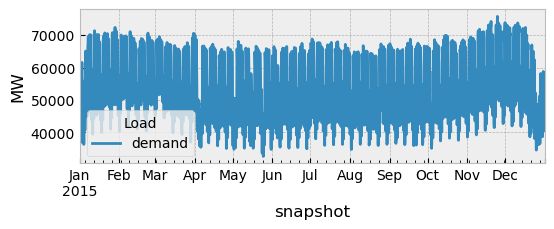

In [17]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

In [18]:
n.add(
    "Generator",
    "OCGT",
    bus = "electricity",
    carrier = "OCGT",
    capital_cost = costs.at["OCGT", "capital_cost"],
    marginal_cost = costs.at["OCGT", "marginal_cost"],
    efficiency = costs.at["OCGT", "efficiency"],
    p_nom_extendable = True,
)

Index(['OCGT'], dtype='object')

In [19]:
vre = ["onwind", "offwind", "solar"]
for tech in vre:
    n.add(
        "Generator",
        tech,
        bus = "electricity",
        carrier = tech,
        p_max_pu = ts[tech],
        capital_cost=costs.at[tech, "capital_cost"],
        marginal_cost=costs.at[tech, "marginal_cost"],
        efficiency=costs.at[tech, "efficiency"],
        p_nom_extendable=True,   
    )

<Axes: xlabel='snapshot'>

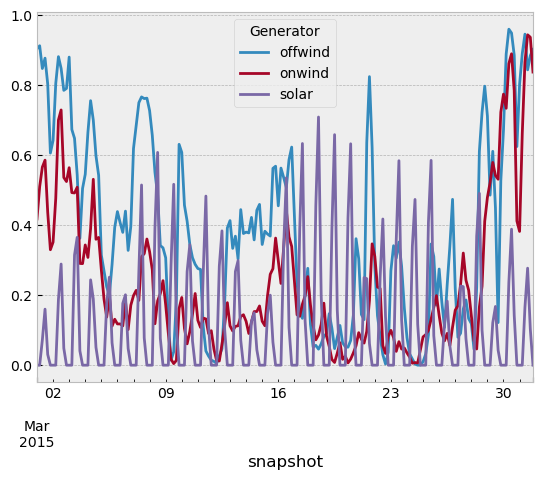

In [20]:
n.generators_t.p_max_pu.loc["2015-03"].plot()

In [21]:
n.optimize(solver_name = "gurobi")

Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io: Writing time: 0.17s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2708452


INFO:gurobipy:Set parameter LicenseID to value 2708452


Academic license - for non-commercial use only - expires 2026-09-13


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-09-13


Read LP format model from file C:\Users\MS\AppData\Local\Temp\linopy-problem-kdt62e6v.lp


INFO:gurobipy:Read LP format model from file C:\Users\MS\AppData\Local\Temp\linopy-problem-kdt62e6v.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 19714 rows, 8764 columns, 33994 nonzeros


INFO:gurobipy:obj: 19714 rows, 8764 columns, 33994 nonzeros


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 19714 rows, 8764 columns and 33994 nonzeros


INFO:gurobipy:Optimize a model with 19714 rows, 8764 columns and 33994 nonzeros


Model fingerprint: 0x41482c5a


INFO:gurobipy:Model fingerprint: 0x41482c5a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-04, 1e+00]


INFO:gurobipy:  Matrix range     [1e-04, 1e+00]


  Objective range  [4e-02, 2e+05]


INFO:gurobipy:  Objective range  [4e-02, 2e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+04, 8e+04]


INFO:gurobipy:  RHS range        [3e+04, 8e+04]


Presolve removed 9814 rows and 1050 columns


INFO:gurobipy:Presolve removed 9814 rows and 1050 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 9900 rows, 7714 columns, 23130 nonzeros


INFO:gurobipy:Presolved: 9900 rows, 7714 columns, 23130 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.542e+04


INFO:gurobipy: AA' NZ     : 1.542e+04


 Factor NZ  : 6.301e+04 (roughly 8 MB of memory)


INFO:gurobipy: Factor NZ  : 6.301e+04 (roughly 8 MB of memory)


 Factor Ops : 4.230e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.230e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.60218458e+10  0.00000000e+00  3.29e+04 0.00e+00  9.52e+07     0s


INFO:gurobipy:   0   8.60218458e+10  0.00000000e+00  3.29e+04 0.00e+00  9.52e+07     0s


   1   7.70172150e+10 -5.37376998e+10  2.66e+03 4.45e+03  2.11e+07     0s


INFO:gurobipy:   1   7.70172150e+10 -5.37376998e+10  2.66e+03 4.45e+03  2.11e+07     0s


   2   5.97162426e+10  1.73858470e+10  5.48e+01 3.67e+01  1.95e+06     0s


INFO:gurobipy:   2   5.97162426e+10  1.73858470e+10  5.48e+01 3.67e+01  1.95e+06     0s


   3   4.19609994e+10  2.54771205e+10  1.96e+01 3.79e+00  7.29e+05     0s


INFO:gurobipy:   3   4.19609994e+10  2.54771205e+10  1.96e+01 3.79e+00  7.29e+05     0s


   4   3.99282362e+10  2.75530916e+10  1.61e+01 2.04e+00  5.45e+05     0s


INFO:gurobipy:   4   3.99282362e+10  2.75530916e+10  1.61e+01 2.04e+00  5.45e+05     0s


   5   3.77190265e+10  2.87220003e+10  1.16e+01 1.33e+00  3.95e+05     0s


INFO:gurobipy:   5   3.77190265e+10  2.87220003e+10  1.16e+01 1.33e+00  3.95e+05     0s


   6   3.68254690e+10  2.95409563e+10  9.86e+00 9.43e-01  3.19e+05     0s


INFO:gurobipy:   6   3.68254690e+10  2.95409563e+10  9.86e+00 9.43e-01  3.19e+05     0s


   7   3.42869976e+10  3.03008883e+10  4.77e+00 5.10e-01  1.74e+05     0s


INFO:gurobipy:   7   3.42869976e+10  3.03008883e+10  4.77e+00 5.10e-01  1.74e+05     0s


   8   3.35089832e+10  3.06422035e+10  3.41e+00 3.75e-01  1.25e+05     0s


INFO:gurobipy:   8   3.35089832e+10  3.06422035e+10  3.41e+00 3.75e-01  1.25e+05     0s


   9   3.32842908e+10  3.07857060e+10  3.03e+00 3.24e-01  1.09e+05     0s


INFO:gurobipy:   9   3.32842908e+10  3.07857060e+10  3.03e+00 3.24e-01  1.09e+05     0s


  10   3.28625379e+10  3.08604313e+10  2.25e+00 2.97e-01  8.76e+04     0s


INFO:gurobipy:  10   3.28625379e+10  3.08604313e+10  2.25e+00 2.97e-01  8.76e+04     0s


  11   3.27719964e+10  3.09520649e+10  2.07e+00 2.63e-01  7.96e+04     0s


INFO:gurobipy:  11   3.27719964e+10  3.09520649e+10  2.07e+00 2.63e-01  7.96e+04     0s


  12   3.25626301e+10  3.09935095e+10  1.71e+00 2.48e-01  6.87e+04     0s


INFO:gurobipy:  12   3.25626301e+10  3.09935095e+10  1.71e+00 2.48e-01  6.87e+04     0s


  13   3.23831068e+10  3.11265930e+10  1.41e+00 1.98e-01  5.50e+04     0s


INFO:gurobipy:  13   3.23831068e+10  3.11265930e+10  1.41e+00 1.98e-01  5.50e+04     0s


  14   3.20709748e+10  3.12055427e+10  7.74e-01 1.68e-01  3.79e+04     0s


INFO:gurobipy:  14   3.20709748e+10  3.12055427e+10  7.74e-01 1.68e-01  3.79e+04     0s


  15   3.20185035e+10  3.12486891e+10  6.82e-01 1.52e-01  3.38e+04     0s


INFO:gurobipy:  15   3.20185035e+10  3.12486891e+10  6.82e-01 1.52e-01  3.38e+04     0s


  16   3.20029807e+10  3.12656247e+10  6.53e-01 1.46e-01  3.23e+04     0s


INFO:gurobipy:  16   3.20029807e+10  3.12656247e+10  6.53e-01 1.46e-01  3.23e+04     0s


  17   3.19915689e+10  3.12877996e+10  6.32e-01 1.37e-01  3.09e+04     0s


INFO:gurobipy:  17   3.19915689e+10  3.12877996e+10  6.32e-01 1.37e-01  3.09e+04     0s


  18   3.19784356e+10  3.13110803e+10  6.08e-01 1.28e-01  2.93e+04     0s


INFO:gurobipy:  18   3.19784356e+10  3.13110803e+10  6.08e-01 1.28e-01  2.93e+04     0s


  19   3.19300660e+10  3.13595282e+10  5.25e-01 1.09e-01  2.50e+04     0s


INFO:gurobipy:  19   3.19300660e+10  3.13595282e+10  5.25e-01 1.09e-01  2.50e+04     0s


  20   3.18612837e+10  3.14107833e+10  4.06e-01 7.08e-02  1.98e+04     0s


INFO:gurobipy:  20   3.18612837e+10  3.14107833e+10  4.06e-01 7.08e-02  1.98e+04     0s


  21   3.17871799e+10  3.14376550e+10  2.74e-01 6.26e-02  1.54e+04     0s


INFO:gurobipy:  21   3.17871799e+10  3.14376550e+10  2.74e-01 6.26e-02  1.54e+04     0s


  22   3.17718345e+10  3.14505038e+10  2.46e-01 5.85e-02  1.41e+04     0s


INFO:gurobipy:  22   3.17718345e+10  3.14505038e+10  2.46e-01 5.85e-02  1.41e+04     0s


  23   3.17471582e+10  3.14637622e+10  2.01e-01 5.43e-02  1.25e+04     0s


INFO:gurobipy:  23   3.17471582e+10  3.14637622e+10  2.01e-01 5.43e-02  1.25e+04     0s


  24   3.17397530e+10  3.14713934e+10  1.81e-01 5.19e-02  1.18e+04     0s


INFO:gurobipy:  24   3.17397530e+10  3.14713934e+10  1.81e-01 5.19e-02  1.18e+04     0s


  25   3.17109803e+10  3.14920032e+10  1.32e-01 4.50e-02  9.64e+03     0s


INFO:gurobipy:  25   3.17109803e+10  3.14920032e+10  1.32e-01 4.50e-02  9.64e+03     0s


  26   3.16937319e+10  3.15065543e+10  1.04e-01 3.31e-02  8.24e+03     0s


INFO:gurobipy:  26   3.16937319e+10  3.15065543e+10  1.04e-01 3.31e-02  8.24e+03     0s


  27   3.16886971e+10  3.15135873e+10  9.63e-02 2.91e-02  7.71e+03     0s


INFO:gurobipy:  27   3.16886971e+10  3.15135873e+10  9.63e-02 2.91e-02  7.71e+03     0s


  28   3.16864568e+10  3.15247322e+10  9.27e-02 2.62e-02  7.12e+03     0s


INFO:gurobipy:  28   3.16864568e+10  3.15247322e+10  9.27e-02 2.62e-02  7.12e+03     0s


  29   3.16692651e+10  3.15359736e+10  6.30e-02 2.33e-02  5.87e+03     0s


INFO:gurobipy:  29   3.16692651e+10  3.15359736e+10  6.30e-02 2.33e-02  5.87e+03     0s


  30   3.16674060e+10  3.15450751e+10  5.92e-02 2.09e-02  5.39e+03     0s


INFO:gurobipy:  30   3.16674060e+10  3.15450751e+10  5.92e-02 2.09e-02  5.39e+03     0s


  31   3.16544663e+10  3.15602235e+10  4.12e-02 1.05e-02  4.15e+03     0s


INFO:gurobipy:  31   3.16544663e+10  3.15602235e+10  4.12e-02 1.05e-02  4.15e+03     0s


  32   3.16531407e+10  3.15622999e+10  3.93e-02 9.23e-03  4.00e+03     0s


INFO:gurobipy:  32   3.16531407e+10  3.15622999e+10  3.93e-02 9.23e-03  4.00e+03     0s


  33   3.16497776e+10  3.15770307e+10  3.43e-02 7.23e-03  3.21e+03     0s


INFO:gurobipy:  33   3.16497776e+10  3.15770307e+10  3.43e-02 7.23e-03  3.21e+03     0s


  34   3.16404839e+10  3.15850944e+10  1.92e-02 5.97e-03  2.45e+03     0s


INFO:gurobipy:  34   3.16404839e+10  3.15850944e+10  1.92e-02 5.97e-03  2.45e+03     0s


  35   3.16350718e+10  3.15964461e+10  1.20e-02 8.32e-05  1.71e+03     0s


INFO:gurobipy:  35   3.16350718e+10  3.15964461e+10  1.20e-02 8.32e-05  1.71e+03     0s


  36   3.16331404e+10  3.15976501e+10  9.83e-03 7.30e-05  1.57e+03     0s


INFO:gurobipy:  36   3.16331404e+10  3.15976501e+10  9.83e-03 7.30e-05  1.57e+03     0s


  37   3.16302032e+10  3.16023177e+10  6.13e-03 1.49e-09  1.23e+03     0s


INFO:gurobipy:  37   3.16302032e+10  3.16023177e+10  6.13e-03 1.49e-09  1.23e+03     0s


  38   3.16292342e+10  3.16033209e+10  5.05e-03 2.36e-09  1.15e+03     0s


INFO:gurobipy:  38   3.16292342e+10  3.16033209e+10  5.05e-03 2.36e-09  1.15e+03     0s


  39   3.16278873e+10  3.16087744e+10  3.43e-03 6.59e-09  8.46e+02     0s


INFO:gurobipy:  39   3.16278873e+10  3.16087744e+10  3.43e-03 6.59e-09  8.46e+02     0s


  40   3.16254035e+10  3.16155616e+10  1.64e-03 7.41e-10  4.37e+02     0s


INFO:gurobipy:  40   3.16254035e+10  3.16155616e+10  1.64e-03 7.41e-10  4.37e+02     0s


  41   3.16247971e+10  3.16242027e+10  1.25e-03 9.95e-05  2.60e+01     0s


INFO:gurobipy:  41   3.16247971e+10  3.16242027e+10  1.25e-03 9.95e-05  2.60e+01     0s


  42   3.16246022e+10  3.16243810e+10  3.42e-04 3.38e-05  9.69e+00     0s


INFO:gurobipy:  42   3.16246022e+10  3.16243810e+10  3.42e-04 3.38e-05  9.69e+00     0s


  43   3.16245578e+10  3.16243939e+10  1.37e-04 3.14e-05  7.20e+00     0s


INFO:gurobipy:  43   3.16245578e+10  3.16243939e+10  1.37e-04 3.14e-05  7.20e+00     0s


  44   3.16245434e+10  3.16245159e+10  6.91e-05 4.17e-10  1.20e+00     0s


INFO:gurobipy:  44   3.16245434e+10  3.16245159e+10  6.91e-05 4.17e-10  1.20e+00     0s


  45   3.16245325e+10  3.16245312e+10  4.29e-06 1.09e-09  5.54e-02     0s


INFO:gurobipy:  45   3.16245325e+10  3.16245312e+10  4.29e-06 1.09e-09  5.54e-02     0s


  46   3.16245319e+10  3.16245319e+10  8.12e-08 1.83e-09  3.66e-04     0s


INFO:gurobipy:  46   3.16245319e+10  3.16245319e+10  8.12e-08 1.83e-09  3.66e-04     0s


  47   3.16245319e+10  3.16245319e+10  2.72e-10 1.43e-11  3.66e-07     0s


INFO:gurobipy:  47   3.16245319e+10  3.16245319e+10  2.72e-10 1.43e-11  3.66e-07     0s


  48   3.16245319e+10  3.16245319e+10  9.76e-10 1.39e-09  3.66e-10     0s


INFO:gurobipy:  48   3.16245319e+10  3.16245319e+10  9.76e-10 1.39e-09  3.66e-10     0s


INFO:gurobipy:


Barrier solved model in 48 iterations and 0.46 seconds (0.16 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 0.46 seconds (0.16 work units)


Optimal objective 3.16245319e+10


INFO:gurobipy:Optimal objective 3.16245319e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2193 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    2193 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0612972e-09      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0612972e-09      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1997    3.1624532e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    1997    3.1624532e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 1997 iterations and 0.53 seconds (0.16 work units)


INFO:gurobipy:Solved in 1997 iterations and 0.53 seconds (0.16 work units)


Optimal objective  3.162453194e+10


INFO:gurobipy:Optimal objective  3.162453194e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 8764 primals, 19714 duals
Objective: 3.16e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [22]:
n.objective/1e9

31.624531940992227

In [23]:
n.generators.p_nom_opt/1e3

Generator
OCGT       70.096357
onwind      0.000000
offwind    49.326062
solar      85.967820
Name: p_nom_opt, dtype: float64

In [24]:
n.snapshot_weightings.generators @ n.generators_t.p/1e6

Generator
OCGT       235.778879
onwind       0.000000
offwind    150.379873
solar       92.766988
Name: generators, dtype: float64

In [25]:
(n.statistics.capex() + n.statistics.opex()).div(1e6)

component  carrier
Generator  OCGT       18596.014468
           offwind     8613.359135
           solar       4415.158338
dtype: float64

In [26]:
emissions = (
    n.generators_t.p
    / n.generators.efficiency
    * n.generators.carrier.map(n.carriers.co2_emissions)
)  # t/h

In [27]:
def plot_dispatch(n, time="2015-07"):
    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)

    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.groupby(n.storage_units.carrier).sum().T.div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    fig, ax = plt.subplots(figsize=(6, 3))

    color = p_by_carrier.columns.map(n.carriers.color)

    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).loc[time]

    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )

    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="k")

    plt.legend(loc=(1.05, 0))
    ax.set_ylabel("GW")
    ax.set_ylim(-200, 200)

C:\Users\MS\AppData\Local\Temp\ipykernel_12700\184362636.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



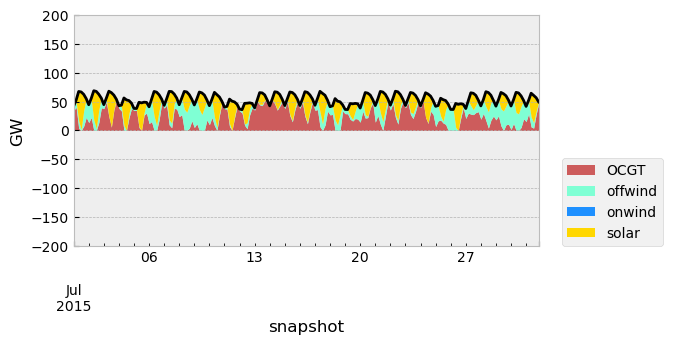

In [28]:
plot_dispatch(n)

In [29]:
n.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=6,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 6 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Index(['battery storage'], dtype='object')

In [30]:
capital_costs = (
    costs.at["electrolysis", "capital_cost"]
    + costs.at["fuel cell", "capital_cost"]
    + 168 * costs.at["hydrogen storage underground", "capital_cost"]
)

n.add(
    "StorageUnit",
    "hydrogen storage underground",
    bus="electricity",
    carrier="hydrogen storage underground",
    max_hours=168,
    capital_cost=capital_costs,
    efficiency_store=costs.at["electrolysis", "efficiency"],
    efficiency_dispatch=costs.at["fuel cell", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Index(['hydrogen storage underground'], dtype='object')

In [31]:
n.optimize(solver_name="gurobi")

Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████| 6/6 [00:00<00:00, 76.17it/s]
INFO:linopy.io: Writing time: 0.53s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2708452


INFO:gurobipy:Set parameter LicenseID to value 2708452


Academic license - for non-commercial use only - expires 2026-09-13


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-09-13


Read LP format model from file C:\Users\MS\AppData\Local\Temp\linopy-problem-zz1k7zsc.lp


INFO:gurobipy:Read LP format model from file C:\Users\MS\AppData\Local\Temp\linopy-problem-zz1k7zsc.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 50376 rows, 21906 columns, 99696 nonzeros


INFO:gurobipy:obj: 50376 rows, 21906 columns, 99696 nonzeros


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 50376 rows, 21906 columns and 99696 nonzeros


INFO:gurobipy:Optimize a model with 50376 rows, 21906 columns and 99696 nonzeros


Model fingerprint: 0xbf6b69c2


INFO:gurobipy:Model fingerprint: 0xbf6b69c2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-04, 2e+02]


INFO:gurobipy:  Matrix range     [1e-04, 2e+02]


  Objective range  [4e-02, 4e+05]


INFO:gurobipy:  Objective range  [4e-02, 4e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+04, 8e+04]


INFO:gurobipy:  RHS range        [3e+04, 8e+04]


Presolve removed 22956 rows and 1050 columns


INFO:gurobipy:Presolve removed 22956 rows and 1050 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 27420 rows, 20856 columns, 75690 nonzeros


INFO:gurobipy:Presolved: 27420 rows, 20856 columns, 75690 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 6.360e+04


INFO:gurobipy: AA' NZ     : 6.360e+04


 Factor NZ  : 4.597e+05 (roughly 23 MB of memory)


INFO:gurobipy: Factor NZ  : 4.597e+05 (roughly 23 MB of memory)


 Factor Ops : 8.067e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.067e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.88891578e+11  0.00000000e+00  4.91e+05 0.00e+00  9.18e+08     0s


INFO:gurobipy:   0   3.88891578e+11  0.00000000e+00  4.91e+05 0.00e+00  9.18e+08     0s


   1   6.63084988e+11 -2.91485156e+11  3.06e+04 1.04e+03  2.42e+08     0s


INFO:gurobipy:   1   6.63084988e+11 -2.91485156e+11  3.06e+04 1.04e+03  2.42e+08     0s


   2   3.75083132e+11 -1.03814990e+10  1.78e+01 5.35e+01  1.95e+07     0s


INFO:gurobipy:   2   3.75083132e+11 -1.03814990e+10  1.78e+01 5.35e+01  1.95e+07     0s


   3   2.06206289e+11  7.46792282e+09  5.71e+00 1.64e+01  7.50e+06     0s


INFO:gurobipy:   3   2.06206289e+11  7.46792282e+09  5.71e+00 1.64e+01  7.50e+06     0s


   4   1.15036051e+11  1.57723986e+10  2.05e+00 4.14e+00  2.94e+06     0s


INFO:gurobipy:   4   1.15036051e+11  1.57723986e+10  2.05e+00 4.14e+00  2.94e+06     0s


   5   6.35193325e+10  2.25860669e+10  6.57e-01 6.89e-01  1.04e+06     0s


INFO:gurobipy:   5   6.35193325e+10  2.25860669e+10  6.57e-01 6.89e-01  1.04e+06     0s


   6   4.56291793e+10  2.57715038e+10  2.88e-01 2.40e-01  4.90e+05     0s


INFO:gurobipy:   6   4.56291793e+10  2.57715038e+10  2.88e-01 2.40e-01  4.90e+05     0s


   7   3.90240117e+10  2.73367532e+10  1.54e-01 8.21e-02  2.86e+05     0s


INFO:gurobipy:   7   3.90240117e+10  2.73367532e+10  1.54e-01 8.21e-02  2.86e+05     0s


   8   3.61944324e+10  2.83948043e+10  9.62e-02 2.26e-02  1.90e+05     0s


INFO:gurobipy:   8   3.61944324e+10  2.83948043e+10  9.62e-02 2.26e-02  1.90e+05     0s


   9   3.55235730e+10  2.90279366e+10  8.22e-02 4.77e-02  1.58e+05     0s


INFO:gurobipy:   9   3.55235730e+10  2.90279366e+10  8.22e-02 4.77e-02  1.58e+05     0s


  10   3.51152928e+10  2.94374106e+10  7.37e-02 6.20e-02  1.38e+05     0s


INFO:gurobipy:  10   3.51152928e+10  2.94374106e+10  7.37e-02 6.20e-02  1.38e+05     0s


  11   3.44685513e+10  3.01517194e+10  5.96e-02 4.76e-02  1.05e+05     0s


INFO:gurobipy:  11   3.44685513e+10  3.01517194e+10  5.96e-02 4.76e-02  1.05e+05     0s


  12   3.40289470e+10  3.06829166e+10  4.99e-02 2.22e-02  8.08e+04     1s


INFO:gurobipy:  12   3.40289470e+10  3.06829166e+10  4.99e-02 2.22e-02  8.08e+04     1s


  13   3.34457930e+10  3.08468646e+10  3.83e-02 3.04e-04  6.27e+04     1s


INFO:gurobipy:  13   3.34457930e+10  3.08468646e+10  3.83e-02 3.04e-04  6.27e+04     1s


  14   3.34551592e+10  3.09084634e+10  3.70e-02 4.09e-04  6.14e+04     1s


INFO:gurobipy:  14   3.34551592e+10  3.09084634e+10  3.70e-02 4.09e-04  6.14e+04     1s


  15   3.28810425e+10  3.12221922e+10  2.27e-02 2.48e-10  4.00e+04     1s


INFO:gurobipy:  15   3.28810425e+10  3.12221922e+10  2.27e-02 2.48e-10  4.00e+04     1s


  16   3.26285608e+10  3.12514360e+10  1.77e-02 1.10e-10  3.32e+04     1s


INFO:gurobipy:  16   3.26285608e+10  3.12514360e+10  1.77e-02 1.10e-10  3.32e+04     1s


  17   3.24904042e+10  3.14292438e+10  1.51e-02 1.93e-10  2.55e+04     1s


INFO:gurobipy:  17   3.24904042e+10  3.14292438e+10  1.51e-02 1.93e-10  2.55e+04     1s


  18   3.24215928e+10  3.14703983e+10  1.38e-02 1.38e-09  2.29e+04     1s


INFO:gurobipy:  18   3.24215928e+10  3.14703983e+10  1.38e-02 1.38e-09  2.29e+04     1s


  19   3.22880285e+10  3.15100578e+10  1.14e-02 2.10e-10  1.87e+04     1s


INFO:gurobipy:  19   3.22880285e+10  3.15100578e+10  1.14e-02 2.10e-10  1.87e+04     1s


  20   3.21298314e+10  3.15358027e+10  8.55e-03 8.79e-11  1.43e+04     1s


INFO:gurobipy:  20   3.21298314e+10  3.15358027e+10  8.55e-03 8.79e-11  1.43e+04     1s


  21   3.21185615e+10  3.15434080e+10  8.35e-03 4.26e-10  1.38e+04     1s


INFO:gurobipy:  21   3.21185615e+10  3.15434080e+10  8.35e-03 4.26e-10  1.38e+04     1s


  22   3.19696191e+10  3.15588883e+10  5.79e-03 1.75e-09  9.88e+03     1s


INFO:gurobipy:  22   3.19696191e+10  3.15588883e+10  5.79e-03 1.75e-09  9.88e+03     1s


  23   3.19206597e+10  3.15837370e+10  4.91e-03 8.09e-11  8.10e+03     1s


INFO:gurobipy:  23   3.19206597e+10  3.15837370e+10  4.91e-03 8.09e-11  8.10e+03     1s


  24   3.18718283e+10  3.15911753e+10  4.07e-03 8.16e-11  6.75e+03     1s


INFO:gurobipy:  24   3.18718283e+10  3.15911753e+10  4.07e-03 8.16e-11  6.75e+03     1s


  25   3.18087383e+10  3.15971757e+10  3.01e-03 1.87e-10  5.09e+03     1s


INFO:gurobipy:  25   3.18087383e+10  3.15971757e+10  3.01e-03 1.87e-10  5.09e+03     1s


  26   3.17725010e+10  3.16041310e+10  2.40e-03 2.44e-11  4.05e+03     1s


INFO:gurobipy:  26   3.17725010e+10  3.16041310e+10  2.40e-03 2.44e-11  4.05e+03     1s


  27   3.17391910e+10  3.16093518e+10  1.85e-03 8.07e-10  3.12e+03     1s


INFO:gurobipy:  27   3.17391910e+10  3.16093518e+10  1.85e-03 8.07e-10  3.12e+03     1s


  28   3.17149086e+10  3.16158623e+10  1.44e-03 1.49e-10  2.38e+03     1s


INFO:gurobipy:  28   3.17149086e+10  3.16158623e+10  1.44e-03 1.49e-10  2.38e+03     1s


  29   3.16969232e+10  3.16195720e+10  1.14e-03 3.26e-10  1.86e+03     1s


INFO:gurobipy:  29   3.16969232e+10  3.16195720e+10  1.14e-03 3.26e-10  1.86e+03     1s


  30   3.16793473e+10  3.16204987e+10  8.65e-04 6.78e-10  1.41e+03     1s


INFO:gurobipy:  30   3.16793473e+10  3.16204987e+10  8.65e-04 6.78e-10  1.41e+03     1s


  31   3.16635201e+10  3.16212825e+10  6.06e-04 3.82e-10  1.01e+03     1s


INFO:gurobipy:  31   3.16635201e+10  3.16212825e+10  6.06e-04 3.82e-10  1.01e+03     1s


  32   3.16585108e+10  3.16219443e+10  5.24e-04 5.80e-10  8.78e+02     1s


INFO:gurobipy:  32   3.16585108e+10  3.16219443e+10  5.24e-04 5.80e-10  8.78e+02     1s


  33   3.16471534e+10  3.16225480e+10  3.43e-04 6.99e-10  5.91e+02     1s


INFO:gurobipy:  33   3.16471534e+10  3.16225480e+10  3.43e-04 6.99e-10  5.91e+02     1s


  34   3.16389321e+10  3.16236235e+10  2.14e-04 1.17e-09  3.67e+02     1s


INFO:gurobipy:  34   3.16389321e+10  3.16236235e+10  2.14e-04 1.17e-09  3.67e+02     1s


  35   3.16372181e+10  3.16237122e+10  1.88e-04 9.43e-10  3.24e+02     1s


INFO:gurobipy:  35   3.16372181e+10  3.16237122e+10  1.88e-04 9.43e-10  3.24e+02     1s


  36   3.16358884e+10  3.16238172e+10  1.68e-04 6.11e-10  2.90e+02     1s


INFO:gurobipy:  36   3.16358884e+10  3.16238172e+10  1.68e-04 6.11e-10  2.90e+02     1s


  37   3.16354336e+10  3.16238680e+10  1.61e-04 4.53e-10  2.78e+02     1s


INFO:gurobipy:  37   3.16354336e+10  3.16238680e+10  1.61e-04 4.53e-10  2.78e+02     1s


  38   3.16337157e+10  3.16239543e+10  1.35e-04 5.12e-10  2.34e+02     1s


INFO:gurobipy:  38   3.16337157e+10  3.16239543e+10  1.35e-04 5.12e-10  2.34e+02     1s


  39   3.16295065e+10  3.16242383e+10  6.94e-05 5.88e-10  1.26e+02     1s


INFO:gurobipy:  39   3.16295065e+10  3.16242383e+10  6.94e-05 5.88e-10  1.26e+02     1s


  40   3.16256260e+10  3.16244880e+10  1.47e-05 1.24e-09  2.73e+01     1s


INFO:gurobipy:  40   3.16256260e+10  3.16244880e+10  1.47e-05 1.24e-09  2.73e+01     1s


  41   3.16252880e+10  3.16245137e+10  9.96e-06 1.67e-09  1.86e+01     1s


INFO:gurobipy:  41   3.16252880e+10  3.16245137e+10  9.96e-06 1.67e-09  1.86e+01     1s


  42   3.16249814e+10  3.16245224e+10  6.66e-06 1.31e-09  1.10e+01     1s


INFO:gurobipy:  42   3.16249814e+10  3.16245224e+10  6.66e-06 1.31e-09  1.10e+01     1s


  43   3.16245923e+10  3.16245302e+10  2.37e-06 1.29e-09  1.49e+00     1s


INFO:gurobipy:  43   3.16245923e+10  3.16245302e+10  2.37e-06 1.29e-09  1.49e+00     1s


  44   3.16245321e+10  3.16245319e+10  9.40e-07 4.99e-10  3.95e-03     1s


INFO:gurobipy:  44   3.16245321e+10  3.16245319e+10  9.40e-07 4.99e-10  3.95e-03     1s


  45   3.16245319e+10  3.16245319e+10  7.51e-08 4.32e-10  3.95e-06     1s


INFO:gurobipy:  45   3.16245319e+10  3.16245319e+10  7.51e-08 4.32e-10  3.95e-06     1s


  46   3.16245319e+10  3.16245319e+10  1.16e-10 2.21e-09  3.95e-09     2s


INFO:gurobipy:  46   3.16245319e+10  3.16245319e+10  1.16e-10 2.21e-09  3.95e-09     2s


INFO:gurobipy:


Barrier solved model in 46 iterations and 1.53 seconds (0.64 work units)


INFO:gurobipy:Barrier solved model in 46 iterations and 1.53 seconds (0.64 work units)


Optimal objective 3.16245319e+10


INFO:gurobipy:Optimal objective 3.16245319e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   19752 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   19752 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0317676e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0317676e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    9140    3.1624532e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    9140    3.1624532e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 9140 iterations and 1.65 seconds (0.67 work units)


INFO:gurobipy:Solved in 9140 iterations and 1.65 seconds (0.67 work units)


Optimal objective  3.162453194e+10


INFO:gurobipy:Optimal objective  3.162453194e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21906 primals, 50376 duals
Objective: 3.16e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [32]:
n.generators.p_nom_opt  # MW

Generator
OCGT       70096.356831
onwind         0.000000
offwind    49326.061998
solar      85967.819687
Name: p_nom_opt, dtype: float64

In [33]:
n.storage_units.p_nom_opt  # MW

StorageUnit
battery storage                 0.0
hydrogen storage underground    0.0
Name: p_nom_opt, dtype: float64

In [34]:
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=0,
)

Index(['CO2Limit'], dtype='object')

In [35]:
n.optimize(solver_name="gurobi")

Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████| 6/6 [00:00<00:00, 97.20it/s]
INFO:linopy.io: Writing time: 0.55s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2708452


INFO:gurobipy:Set parameter LicenseID to value 2708452


Academic license - for non-commercial use only - expires 2026-09-13


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-09-13


Read LP format model from file C:\Users\MS\AppData\Local\Temp\linopy-problem-ytrac8eq.lp


INFO:gurobipy:Read LP format model from file C:\Users\MS\AppData\Local\Temp\linopy-problem-ytrac8eq.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 50377 rows, 21906 columns, 101886 nonzeros


INFO:gurobipy:obj: 50377 rows, 21906 columns, 101886 nonzeros


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 50377 rows, 21906 columns and 101886 nonzeros


INFO:gurobipy:Optimize a model with 50377 rows, 21906 columns and 101886 nonzeros


Model fingerprint: 0x65c47b7a


INFO:gurobipy:Model fingerprint: 0x65c47b7a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-04, 2e+02]


INFO:gurobipy:  Matrix range     [1e-04, 2e+02]


  Objective range  [4e-02, 4e+05]


INFO:gurobipy:  Objective range  [4e-02, 4e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+04, 8e+04]


INFO:gurobipy:  RHS range        [3e+04, 8e+04]


Presolve removed 25147 rows and 3241 columns


INFO:gurobipy:Presolve removed 25147 rows and 3241 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 25230 rows, 18665 columns, 69120 nonzeros


INFO:gurobipy:Presolved: 25230 rows, 18665 columns, 69120 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 5.922e+04


INFO:gurobipy: AA' NZ     : 5.922e+04


 Factor NZ  : 3.852e+05 (roughly 20 MB of memory)


INFO:gurobipy: Factor NZ  : 3.852e+05 (roughly 20 MB of memory)


 Factor Ops : 6.160e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.160e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.60388948e+11  0.00000000e+00  4.22e+05 0.00e+00  9.95e+08     0s


INFO:gurobipy:   0   3.60388948e+11  0.00000000e+00  4.22e+05 0.00e+00  9.95e+08     0s


   1   7.41432587e+11 -2.15314416e+11  1.66e+04 9.90e+02  2.65e+08     0s


INFO:gurobipy:   1   7.41432587e+11 -2.15314416e+11  1.66e+04 9.90e+02  2.65e+08     0s


   2   4.13094714e+11 -8.51675518e+08  2.35e-08 1.08e+02  3.51e+07     0s


INFO:gurobipy:   2   4.13094714e+11 -8.51675518e+08  2.35e-08 1.08e+02  3.51e+07     0s


   3   2.33544694e+11  1.78939066e+10  9.26e-09 2.71e+01  1.10e+07     0s


INFO:gurobipy:   3   2.33544694e+11  1.78939066e+10  9.26e-09 2.71e+01  1.10e+07     0s


   4   1.47736103e+11  2.43786454e+10  1.91e-08 9.99e+00  4.80e+06     0s


INFO:gurobipy:   4   1.47736103e+11  2.43786454e+10  1.91e-08 9.99e+00  4.80e+06     0s


   5   1.13696564e+11  3.26110624e+10  4.42e-08 4.23e+00  2.71e+06     0s


INFO:gurobipy:   5   1.13696564e+11  3.26110624e+10  4.42e-08 4.23e+00  2.71e+06     0s


   6   1.11688234e+11  4.03410129e+10  1.33e-07 2.28e+00  2.19e+06     0s


INFO:gurobipy:   6   1.11688234e+11  4.03410129e+10  1.33e-07 2.28e+00  2.19e+06     0s


   7   1.02161857e+11  4.49170411e+10  5.99e-07 1.86e+00  1.75e+06     0s


INFO:gurobipy:   7   1.02161857e+11  4.49170411e+10  5.99e-07 1.86e+00  1.75e+06     0s


   8   9.14245093e+10  5.38849744e+10  2.37e-06 1.25e+00  1.15e+06     0s


INFO:gurobipy:   8   9.14245093e+10  5.38849744e+10  2.37e-06 1.25e+00  1.15e+06     0s


   9   8.60999876e+10  6.67720822e+10  2.49e-06 4.40e-01  5.64e+05     0s


INFO:gurobipy:   9   8.60999876e+10  6.67720822e+10  2.49e-06 4.40e-01  5.64e+05     0s


  10   8.54294361e+10  6.92630500e+10  2.41e-06 3.30e-01  4.67e+05     0s


INFO:gurobipy:  10   8.54294361e+10  6.92630500e+10  2.41e-06 3.30e-01  4.67e+05     0s


  11   8.36038157e+10  7.19229012e+10  2.77e-06 2.23e-01  3.36e+05     0s


INFO:gurobipy:  11   8.36038157e+10  7.19229012e+10  2.77e-06 2.23e-01  3.36e+05     0s


  12   8.20455709e+10  7.36474107e+10  4.08e-06 1.59e-01  2.41e+05     0s


INFO:gurobipy:  12   8.20455709e+10  7.36474107e+10  4.08e-06 1.59e-01  2.41e+05     0s


  13   8.09204643e+10  7.57655522e+10  8.84e-06 8.53e-02  1.46e+05     0s


INFO:gurobipy:  13   8.09204643e+10  7.57655522e+10  8.84e-06 8.53e-02  1.46e+05     0s


  14   8.08131996e+10  7.67271074e+10  8.50e-06 6.11e-02  1.15e+05     1s


INFO:gurobipy:  14   8.08131996e+10  7.67271074e+10  8.50e-06 6.11e-02  1.15e+05     1s


  15   8.05578506e+10  7.71867214e+10  9.55e-06 4.73e-02  9.49e+04     1s


INFO:gurobipy:  15   8.05578506e+10  7.71867214e+10  9.55e-06 4.73e-02  9.49e+04     1s


  16   8.03174038e+10  7.76077373e+10  1.76e-05 3.55e-02  7.61e+04     1s


INFO:gurobipy:  16   8.03174038e+10  7.76077373e+10  1.76e-05 3.55e-02  7.61e+04     1s


  17   8.01048561e+10  7.83816013e+10  4.21e-05 1.83e-02  4.80e+04     1s


INFO:gurobipy:  17   8.01048561e+10  7.83816013e+10  4.21e-05 1.83e-02  4.80e+04     1s


  18   7.98625569e+10  7.86170315e+10  6.03e-05 1.44e-02  3.48e+04     1s


INFO:gurobipy:  18   7.98625569e+10  7.86170315e+10  6.03e-05 1.44e-02  3.48e+04     1s


  19   7.97775863e+10  7.88795196e+10  3.94e-05 9.25e-03  2.50e+04     1s


INFO:gurobipy:  19   7.97775863e+10  7.88795196e+10  3.94e-05 9.25e-03  2.50e+04     1s


  20   7.96314919e+10  7.91523066e+10  8.27e-05 4.40e-03  1.33e+04     1s


INFO:gurobipy:  20   7.96314919e+10  7.91523066e+10  8.27e-05 4.40e-03  1.33e+04     1s


  21   7.95743662e+10  7.93201721e+10  6.32e-05 1.72e-03  7.01e+03     1s


INFO:gurobipy:  21   7.95743662e+10  7.93201721e+10  6.32e-05 1.72e-03  7.01e+03     1s


  22   7.95358256e+10  7.93688089e+10  5.66e-05 9.62e-04  4.59e+03     1s


INFO:gurobipy:  22   7.95358256e+10  7.93688089e+10  5.66e-05 9.62e-04  4.59e+03     1s


  23   7.94894265e+10  7.94119626e+10  7.29e-05 2.69e-04  2.11e+03     1s


INFO:gurobipy:  23   7.94894265e+10  7.94119626e+10  7.29e-05 2.69e-04  2.11e+03     1s


  24   7.94631559e+10  7.94300027e+10  5.57e-05 5.68e-05  8.96e+02     1s


INFO:gurobipy:  24   7.94631559e+10  7.94300027e+10  5.57e-05 5.68e-05  8.96e+02     1s


  25   7.94481642e+10  7.94349106e+10  6.41e-05 1.29e-05  3.58e+02     1s


INFO:gurobipy:  25   7.94481642e+10  7.94349106e+10  6.41e-05 1.29e-05  3.58e+02     1s


  26   7.94424402e+10  7.94359175e+10  2.45e-05 6.51e-06  1.76e+02     1s


INFO:gurobipy:  26   7.94424402e+10  7.94359175e+10  2.45e-05 6.51e-06  1.76e+02     1s


  27   7.94417024e+10  7.94361458e+10  2.11e-05 5.19e-06  1.50e+02     1s


INFO:gurobipy:  27   7.94417024e+10  7.94361458e+10  2.11e-05 5.19e-06  1.50e+02     1s


  28   7.94414542e+10  7.94365398e+10  2.01e-05 3.88e-06  1.33e+02     1s


INFO:gurobipy:  28   7.94414542e+10  7.94365398e+10  2.01e-05 3.88e-06  1.33e+02     1s


  29   7.94388501e+10  7.94374309e+10  2.37e-05 2.48e-10  3.81e+01     1s


INFO:gurobipy:  29   7.94388501e+10  7.94374309e+10  2.37e-05 2.48e-10  3.81e+01     1s


  30   7.94382199e+10  7.94376197e+10  9.45e-06 4.46e-10  1.61e+01     1s


INFO:gurobipy:  30   7.94382199e+10  7.94376197e+10  9.45e-06 4.46e-10  1.61e+01     1s


  31   7.94379616e+10  7.94376981e+10  3.78e-06 5.88e-10  7.08e+00     1s


INFO:gurobipy:  31   7.94379616e+10  7.94376981e+10  3.78e-06 5.88e-10  7.08e+00     1s


  32   7.94377896e+10  7.94377595e+10  3.73e-08 3.34e-10  8.11e-01     1s


INFO:gurobipy:  32   7.94377896e+10  7.94377595e+10  3.73e-08 3.34e-10  8.11e-01     1s


  33   7.94377839e+10  7.94377789e+10  1.57e-08 8.47e-10  1.33e-01     1s


INFO:gurobipy:  33   7.94377839e+10  7.94377789e+10  1.57e-08 8.47e-10  1.33e-01     1s


  34   7.94377827e+10  7.94377823e+10  5.42e-08 2.26e-10  1.05e-02     1s


INFO:gurobipy:  34   7.94377827e+10  7.94377823e+10  5.42e-08 2.26e-10  1.05e-02     1s


  35   7.94377826e+10  7.94377826e+10  1.44e-04 1.62e-09  5.24e-04     1s


INFO:gurobipy:  35   7.94377826e+10  7.94377826e+10  1.44e-04 1.62e-09  5.24e-04     1s


  36   7.94377826e+10  7.94377826e+10  5.93e-08 2.14e-09  1.76e-07     1s


INFO:gurobipy:  36   7.94377826e+10  7.94377826e+10  5.93e-08 2.14e-09  1.76e-07     1s


  37   7.94377826e+10  7.94377826e+10  1.68e-08 2.01e-09  2.25e-10     1s


INFO:gurobipy:  37   7.94377826e+10  7.94377826e+10  1.68e-08 2.01e-09  2.25e-10     1s


INFO:gurobipy:


Barrier solved model in 37 iterations and 1.14 seconds (0.50 work units)


INFO:gurobipy:Barrier solved model in 37 iterations and 1.14 seconds (0.50 work units)


Optimal objective 7.94377826e+10


INFO:gurobipy:Optimal objective 7.94377826e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


     158 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:     158 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    2325 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    2325 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6602085e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6602085e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2486    7.9437783e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    2486    7.9437783e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 2486 iterations and 1.29 seconds (0.57 work units)


INFO:gurobipy:Solved in 2486 iterations and 1.29 seconds (0.57 work units)


Optimal objective  7.943778261e+10


INFO:gurobipy:Optimal objective  7.943778261e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21906 primals, 50377 duals
Objective: 7.94e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [36]:
n.generators.p_nom_opt  # MW

Generator
OCGT            0.000000
onwind     267431.119057
offwind     61878.836900
solar      288960.778468
Name: p_nom_opt, dtype: float64

In [37]:
n.storage_units.p_nom_opt.div(1e3)

StorageUnit
battery storage                 50.461162
hydrogen storage underground    48.721593
Name: p_nom_opt, dtype: float64

In [38]:
n.storage_units.p_nom_opt.div(1e3) * n.storage_units.max_hours  # GWh

StorageUnit
battery storage                  302.766972
hydrogen storage underground    8185.227697
dtype: float64

C:\Users\MS\AppData\Local\Temp\ipykernel_12700\184362636.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\MS\anaconda3\envs\esm-ws-24-25\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



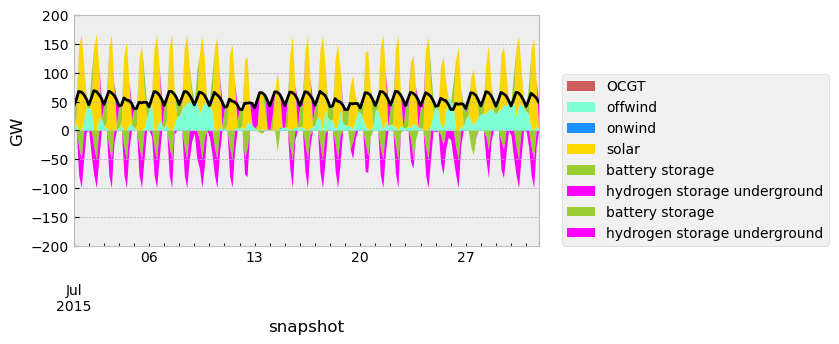

In [39]:
plot_dispatch(n)

In [40]:
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a

In [41]:
system_cost(n)

carrier
offwind                         10805.272422
onwind                          27292.531677
solar                           14840.420429
battery storage                          NaN
hydrogen storage underground             NaN
dtype: float64

<Axes: >

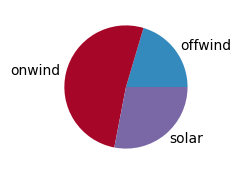

In [42]:
system_cost(n).plot.pie(figsize=(2, 2))

In [43]:
demand = n.snapshot_weightings.generators @ n.loads_t.p_set.sum(axis=1)

In [44]:
LCOE = system_cost(n).sum() * 1e6 / demand.sum()
print(f"Levelized cost of the system is {LCOE:.2f} EUR/a")

Levelized cost of the system is 110.54 EUR/a
